In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

import time
import matplotlib 

import os
import sys
# Add the parent directory to sys.path to find the utils package
module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path:
    sys.path.append(module_path)

from utils.colormaps import b_viridis, b_winter  

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
# define model
sig_n = 30
drone_net = torch.jit.load('drone_net.pt')
drone_net.to(device)
print(drone_net)

# load checkpoint
chk_fn = f'checkpoint.pt'
state_dict = torch.load(chk_fn)

scaling = state_dict['scaling']
params = state_dict['recon_tissues']

print(state_dict.keys(), params)
scaling


RecursiveScriptModule(
  original_name=Network
  (input): RecursiveScriptModule(original_name=Linear)
  (middle): RecursiveScriptModule(original_name=Linear)
  (output): RecursiveScriptModule(original_name=Linear)
)
dict_keys(['model_state_dict', 'scaling', 'recon_tissues']) ['T1w', 'T2w', 'Ksw', 'Kssw', 'M0s', 'M0ss']


{'T1w': 7999.883333333333,
 'T2w': 5998.743333333334,
 'T1s': 2900.0,
 'T2s': 8.0,
 'T1ss': 2900.0,
 'T2ss': 0.6,
 'T1a': 2900.0,
 'T2a': 2.0,
 'Ksw': 159.998,
 'Kssw': 199.9967,
 'Kaw': 20.0,
 'Kas': 1,
 'Ksa': 1,
 'KsSS': 1,
 'KSSs': 1,
 'Kass': 1,
 'Kssa': 1,
 'M0s': 0.018181515454545452,
 'M0ss': 0.27272272757575755,
 'M0a': 1,
 'B0shift': 1,
 'B1scaling': 2.3999733333333335}

In [4]:
# load data
data_fn = f'data_to_match.npy'
acquired_data  = np.load(data_fn)

acquired_data.shape

(30, 256, 256)

In [5]:
_, c_acq_data, w_acq_data = np.shape(acquired_data)

# Reshaping the acquired data to the shape expected by the NN (e.g. 30 x ... )
data = np.reshape(acquired_data, (sig_n, c_acq_data * w_acq_data), order='F')
data = data / (np.linalg.norm(data, ord=2, axis=0) + 1e-8)

# Transposing for compatibility with the NN - now each row is a trajectory
data = data.T
data = torch.from_numpy(data).to(device).float()

# Switching to evaluation mode
drone_net.eval()

t0 = time.time()
prediction = drone_net(data)
print(f"Prediction took {time.time() - t0:.5f} seconds")

# scaling the prediction
for i, param in enumerate(params):
    prediction[:, i] = prediction[:, i] * scaling[param]


Prediction took 0.86589 seconds


In [6]:
# Reshaping back to the image dimension

quant_maps = {}
for i, param in enumerate(params):
    quant_maps[param] = prediction[:, i].detach().cpu().numpy()
    quant_maps[param] = quant_maps[param].T
    quant_maps[param] = np.reshape(quant_maps[param], (c_acq_data, w_acq_data), order='F')

In [7]:
# load brain mask (created with SAM model)
mask_fn = 'drone_mask.npy'
mask = np.load(mask_fn)

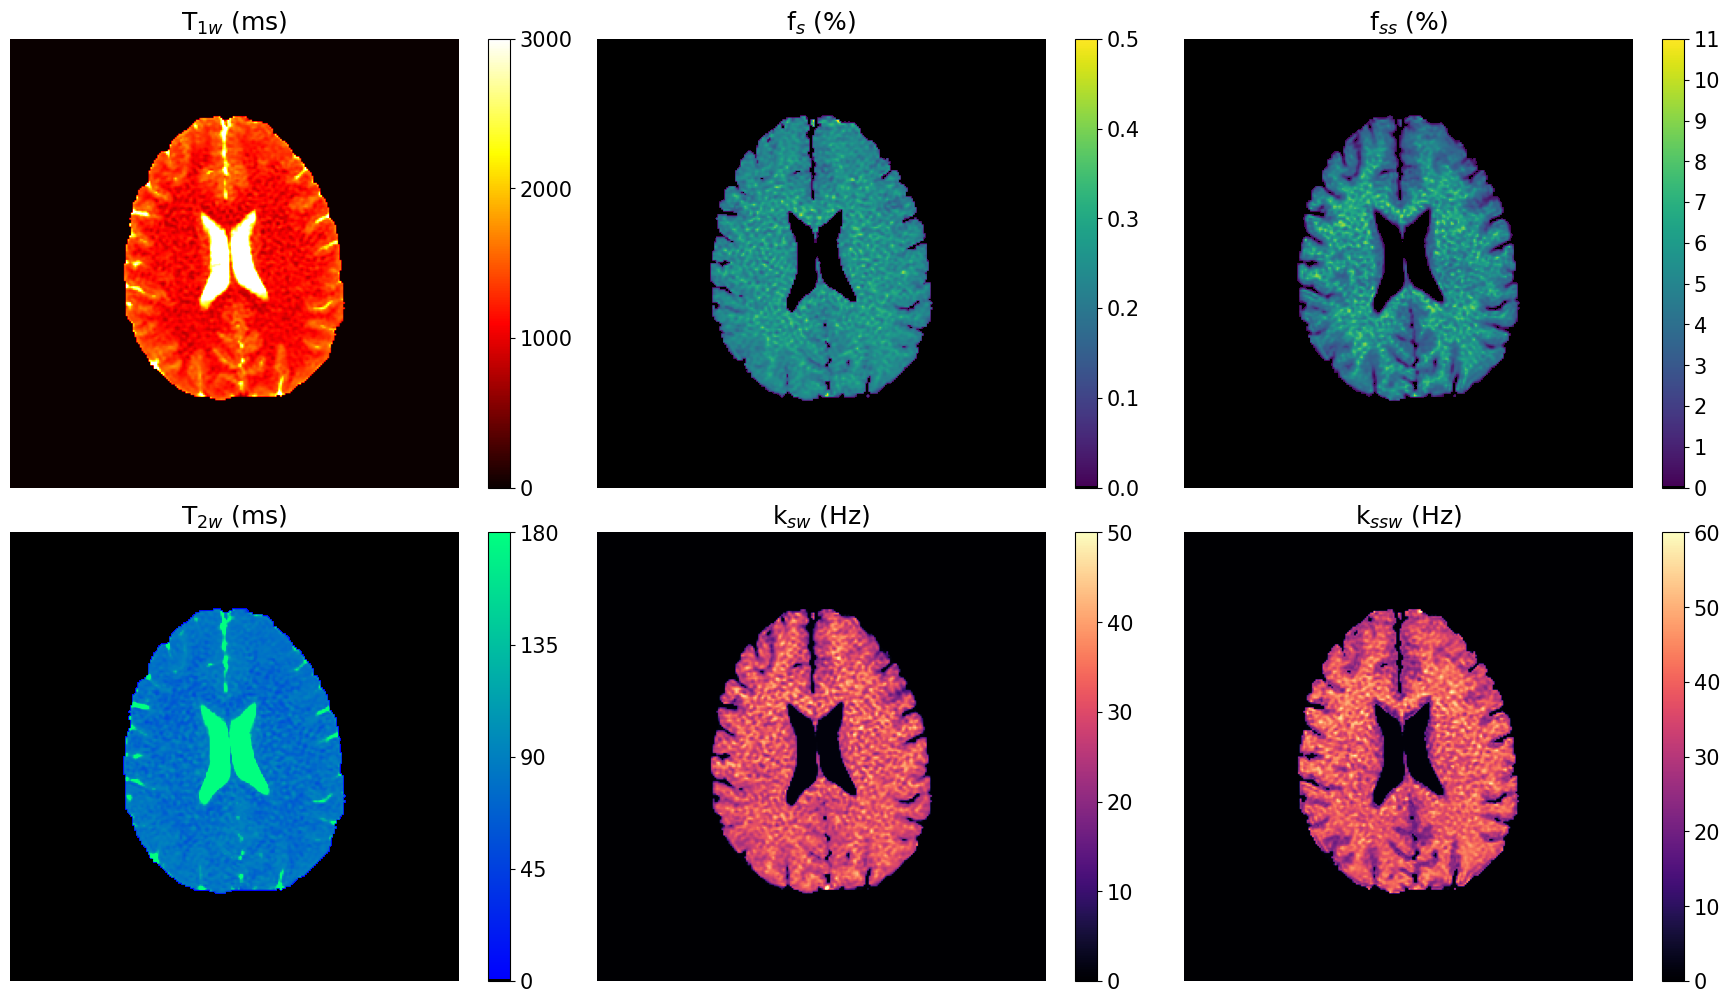

In [8]:
ranges = {
    'T1w': (0, 3000),
    'T2w': (0, 180),
    'M0s': (0, 0.5),
    'M0ss': (0, 11),
    'Ksw': (0, 50),
    'Kssw': (0, 60)
}

ticks = {
    'T1w': np.arange(ranges['T1w'][0], ranges['T1w'][1] + 1000, 1000),
    'T2w': np.arange(ranges['T2w'][0], ranges['T2w'][1] + 50, 45),
    'M0s': np.arange(ranges['M0s'][0], ranges['M0s'][1] + 0.1, 0.1),
    'M0ss': np.arange(ranges['M0ss'][0], ranges['M0ss'][1] + 1 , 1),
    'Ksw': np.arange(ranges['Ksw'][0], ranges['Ksw'][1] + 10, 10),
    'Kssw': np.arange(ranges['Kssw'][0], ranges['Kssw'][1] + 10, 10)
}

colormaps = {
    'T1w': 'hot',
    'T2w': b_winter,
    'M0s': b_viridis,
    'M0ss':  b_viridis,
    'Ksw': 'magma',
    'Kssw': 'magma'
}

positions = {
    'T1w': (0, 0),
    'T2w': (1, 0),
    'M0s': (0, 1),
    'M0ss': (0, 2),
    'Ksw': (1, 1),
    'Kssw': (1, 2)
}


plt.figure(figsize=(18,20))

matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 
plt.rcParams.update({'font.size': 15})

for i, param in enumerate(params):
    position = positions[param]
    # plt.subplot(2, 3, i + 1)
    plt.subplot2grid((4, 3), position)
    signal = quant_maps[param]
    title = param
    if param in ['T1w', 'T2w']:
        title = param[:1] + f'$_{{{param[1:]}}}$' +' (ms)'

    if param in ['M0s', 'M0ss']:
        signal = signal * 100
        title = 'f' + f'$_{{{param[2:]}}}$' +' (%)'
    if param in ['Ksw', 'Kssw']:
        signal = signal
        title = param.lower()[:1] + f'$_{{{param[1:]}}}$' +' (Hz)'
        
    plt.imshow(signal*mask, cmap=colormaps[param])
    plt.title(title)       
    plt.colorbar(orientation='vertical', ticks=ticks[param])
    plt.clim(ranges[param])
    plt.axis('off')
    
plt.tight_layout()
plt.subplots_adjust(wspace=0.01, hspace=0.1)  # Adjust spacing between subplots
